In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_3DLorenz.recursive_LSTM_PostMeanScore_3DLorenz_T256_H05_tl_110data import \
    get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)

2


[Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_4DLorenz_DriftTrack_60Nep_tl110data_00t0_3906e-03dT_1NDT_2LFac_075FConst_global_true_states.npy'
[Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_4DLorenz_DriftTrack_100Nep_tl110data_00t0_3906e-03dT_1NDT_2LFac_075FConst_global_true_states.npy'


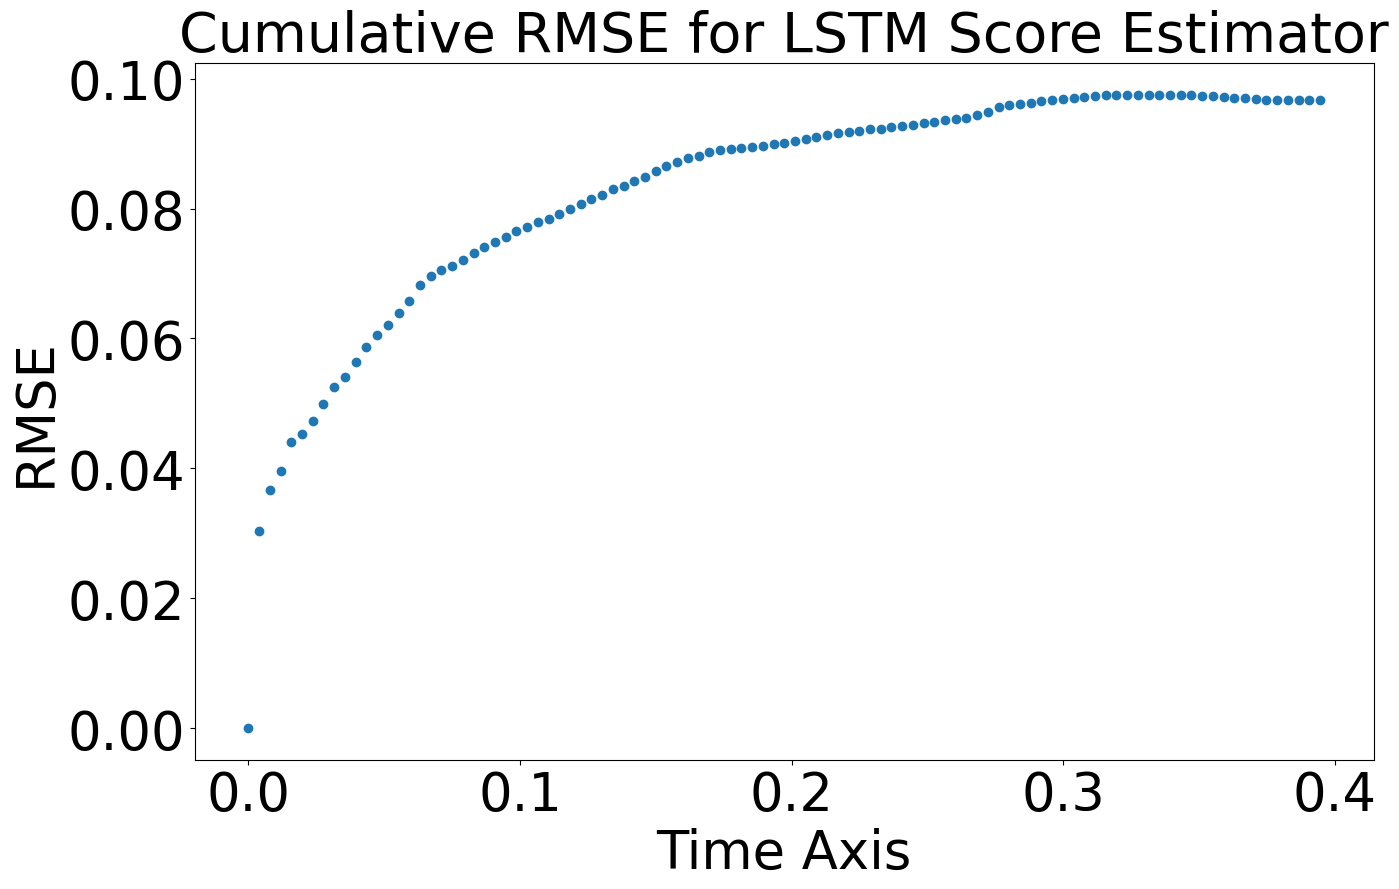

Final time cumulative RMSE local-time error 0.09667963115991453 at Nepoch 150

[Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_4DLorenz_DriftTrack_960Nep_tl110data_00t0_3906e-03dT_1NDT_2LFac_075FConst_global_true_states.npy'
[Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_4DLorenz_DriftTrack_1920Nep_tl110data_00t0_3906e-03dT_1NDT_2LFac_075FConst_global_true_states.npy'
[Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_4DLorenz_DriftTrack_6920Nep_tl110data_00t0_3906e-03dT_1NDT_2LFac_075FConst_global_true_states.npy'
[Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_4DLorenz_DriftTrack_7190Nep_tl110data_00t0_3906e-03dT_1NDT_2LFac_075FConst_global_true_states.npy'
[Errno 2] No such file or directory: '/Users/marco

In [23]:
curr_rmse = np.inf
for Nepoch in config.max_epochs:
    try:
        num_diff_times = 1
        save_path = (
                project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_{config.ndims}DLorenz_DriftTrack_{Nepoch}Nep_tl{config.tdata_mult}data_{config.t0}t0_{config.deltaT:.3e}dT_{num_diff_times}NDT_{config.loss_factor}LFac_{config.ts_beta:.1e}Beta_{config.ts_rho:.1e}Rho_{config.ts_sigma:.1e}Sigma").replace(
            ".", "")
        true_states = np.load(save_path + "_global_true_states.npy")/np.sqrt(config.deltaT)
        local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
        local_errors = np.power(np.cumsum(np.mean(np.power(true_states- local_states,2), axis=0), axis=0), 0.5)
        total_local_errors = np.power(np.sum(np.power(local_errors, 2), axis=1)/np.arange(1, local_errors.shape[0]+1), 0.5)
        if total_local_errors[-1] < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} at Nepoch {Nepoch} for _{config.ts_beta:.1e}Beta_{config.ts_rho:.1e}Rho_{config.ts_sigma:.1e}Sigma\n")
    except FileNotFoundError as e:
        print(e)
        continue